# Day Model for Component 2

After processing the kaggle dataset to include "lag" inputs to our model, this notebook trains a model to predict equipment failures for component 2 in the next 24 hours.

## Data Preperation

### Loading and Building Signal

In [1]:
%cd ../..
from src.data.files import Data
from src.data.synthesizer import MachineSignalSynth, OneHotColumn, JoinColumns, ConvolveBoleanColumns

import pandas as pd
from sklearn.model_selection import train_test_split

COMPONENT = "comp2"
JOIN_COLS = ["error" + str(i) for i in range(1,6)]
JOIN_COLS.extend(["maint_comp" + str(i) for i in range(1,5)])
JOIN_COLS.append("failure_" + COMPONENT)

LABEL = "failure_" + COMPONENT
all_events = Data.get_events()
tel = Data.get_telemetry()
synthesizer_methods = [JoinColumns(JOIN_COLS),
                       OneHotColumn("model"),
                       ConvolveBoleanColumns(cols=JOIN_COLS,
                                             in_place=[False]*(len(JOIN_COLS) - 1) + [True],
                                             label=LABEL,
                                             delta_ts=[24]*len(JOIN_COLS))]
synthesizer = MachineSignalSynth(tel, all_events, synthesizer_methods)
raw_signal = synthesizer.generate()

/Users/legross/Code/marching-penguin


In [2]:
ANOMALY = "anomaly"
MODEL = "model"

raw_signal[ANOMALY] = raw_signal[ANOMALY].astype(int)

### Signal Description/Verification

#### Failure Signal

From the all_events data, let's take a look at the first two failures,

In [3]:
all_events.loc[all_events.failure_comp2 == True].head(2)

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4,maint_comp1,maint_comp2,maint_comp3,maint_comp4,error1,error2,error3,error4,error5,failure,maint,error,anomaly
2616,2015-04-20 06:00:00,1,0,1,0,0,0,1,0,0,0,0,0,0,0,True,True,False,True
6936,2015-10-17 06:00:00,1,0,1,0,0,0,1,0,1,0,0,0,0,0,True,True,False,True


The first failure occurs at time stamp "2015-04-20 06:00:00." Our label "failure_comp2" is in the 18th column of the signal. At that time step we expect the label to be 1.0 or True for machineID 1,

In [4]:
raw_signal.loc[(raw_signal.datetime == "2015-04-20 06:00:00") & (raw_signal.machineID == 1)].iloc[:, :18]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,error3,error4,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,failure_comp2
2616,2015-04-20 06:00:00,1,180.050801,346.36248,105.661164,39.218055,18,1,0,0,0,0,0,0,1,0,0,1.0


The convolution filter for the **label** tells us if the label will be true in the **next** 24 hours (since that is what we are trying to predict).

In [5]:
machine_1_signal = raw_signal.loc[raw_signal.machineID == 1]
mask = (machine_1_signal['datetime'] > "2015-04-19 03:00:00") & (machine_1_signal['datetime'] <= "2015-04-20 09:00:00")
machine_1_signal[mask][["datetime", LABEL]]

,datetime,failure_comp2
2590,2015-04-19 04:00:00,0.0
2591,2015-04-19 05:00:00,0.0
2592,2015-04-19 06:00:00,0.0
2593,2015-04-19 07:00:00,1.0
2594,2015-04-19 08:00:00,1.0
2595,2015-04-19 09:00:00,1.0
2596,2015-04-19 10:00:00,1.0
2597,2015-04-19 11:00:00,1.0
2598,2015-04-19 12:00:00,1.0
2599,2015-04-19 13:00:00,1.0


#### Error Signal

Looking at the first two error3 occurences,

In [6]:
all_events.loc[all_events.error3 == True].head(2)

,datetime,machineID,failure_comp1,failure_comp2,failure_comp3,failure_comp4,maint_comp1,maint_comp2,maint_comp3,maint_comp4,error1,error2,error3,error4,error5,failure,maint,error,anomaly
62,2015-01-03 20:00:00,1,0,0,0,0,0,0,0,0,0,0,1,0,0,False,False,True,True
2592,2015-04-19 06:00:00,1,0,0,0,0,0,0,0,0,0,1,1,0,0,False,False,True,True


The first error3 occurs at time stamp "2015-01-03 20:00:00."

In [7]:
raw_signal.loc[(raw_signal.datetime == "2015-01-03 20:00:00") & (raw_signal.machineID == 1)].iloc[:, :18]

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,error3,error4,error5,maint_comp1,maint_comp2,maint_comp3,maint_comp4,failure_comp2
62,2015-01-03 20:00:00,1,163.783704,520.582694,97.160984,56.442488,18,1,0,0,1,0,0,0,0,0,0,0.0


The convolution filter for **features** tells us if something happened in the **past** 24 hours.

In [9]:
machine_1_signal = raw_signal.loc[raw_signal.machineID == 1]
mask = (machine_1_signal['datetime'] > "2015-01-03 18:00:00") & (machine_1_signal['datetime'] <= "2015-01-04 23:00:00")
machine_1_signal[mask][["datetime", "error3_in_past_24"]]

,datetime,error3_in_past_24
61,2015-01-03 19:00:00,0.0
62,2015-01-03 20:00:00,1.0
63,2015-01-03 21:00:00,1.0
64,2015-01-03 22:00:00,1.0
65,2015-01-03 23:00:00,1.0
66,2015-01-04 00:00:00,1.0
67,2015-01-04 01:00:00,1.0
68,2015-01-04 02:00:00,1.0
69,2015-01-04 03:00:00,1.0
70,2015-01-04 04:00:00,1.0


#### General Raw Signal

In [10]:
raw_signal.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_in_past_24,error2_in_past_24,error3_in_past_24,error4_in_past_24,error5_in_past_24,maint_comp1_in_past_24,maint_comp2_in_past_24,maint_comp3_in_past_24,maint_comp4_in_past_24
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(f"Failure vs normal labels: {len(raw_signal.loc[raw_signal[LABEL] == True].index) / len(raw_signal.index) * 100} %")

Failure vs normal labels: 0.7088231936993493 %


## Train/Val/Test Splitting

In [12]:
y = raw_signal.loc[:, raw_signal.columns == LABEL]
X = raw_signal.loc[:, raw_signal.columns != LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

### Sanity Check

Training data starts at earlier timestamps.

In [13]:
X_train.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_in_past_24,error2_in_past_24,error3_in_past_24,error4_in_past_24,error5_in_past_24,maint_comp1_in_past_24,maint_comp2_in_past_24,maint_comp3_in_past_24,maint_comp4_in_past_24
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455572,2015-01-01 06:00:00,53,183.084582,420.980061,109.235805,45.737760,5,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858578,2015-01-01 06:00:00,99,168.596133,384.747105,110.921131,41.944692,14,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96371,2015-01-01 06:00:00,12,171.404215,576.923563,97.145400,47.725909,9,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43805,2015-01-01 06:00:00,6,136.878588,492.088420,149.003582,22.973289,7,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation is later.

In [14]:
X_val

,datetime,machineID,volt,rotate,pressure,vibration,age,anomaly,error1,error2,...,model4,error1_in_past_24,error2_in_past_24,error3_in_past_24,error4_in_past_24,error5_in_past_24,maint_comp1_in_past_24,maint_comp2_in_past_24,maint_comp3_in_past_24,maint_comp4_in_past_24
250564,2015-08-08 06:00:00,29,171.282232,481.209996,102.743036,39.519892,3,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408262,2015-08-08 06:00:00,47,178.795044,426.146721,105.017558,39.001777,6,0,0,0,...,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
662331,2015-08-08 06:00:00,76,183.061932,449.149734,98.230997,45.061041,10,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
574721,2015-08-08 06:00:00,66,164.209160,412.533084,93.624311,41.463793,6,0,0,0,...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
487111,2015-08-08 06:00:00,56,177.870183,449.365869,94.093720,45.531205,10,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366209,2015-10-20 06:00:00,42,158.452457,405.129364,106.064339,34.101076,7,0,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629039,2015-10-20 06:00:00,72,164.552195,376.148556,93.900139,40.664033,2,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
226033,2015-10-20 06:00:00,26,172.369838,455.760415,103.049543,38.858137,3,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681605,2015-10-20 06:00:00,78,179.076624,449.013090,82.255674,50.094108,19,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Formatting for Sagemaker

In [15]:
train = pd.concat([y_train, X_train], axis=1)
validation = pd.concat([y_val, X_val], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [16]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

### Upload Data for Training, Validation, and Testing

In [17]:
import sagemaker, boto3, os
bucket = "pmpf-data"
prefix = "sagemaker-xgboost-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train_02_12_12.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation_02_12_12.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test_02_12_12.csv')).upload_file('test.csv')

## Local Model Development/Analysis

Testing a decision tree classifier locally to see results.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [19]:
model_a = DecisionTreeClassifier(max_depth=3)
model_a.fit(X_train.iloc[:, 1:],y_train)

DecisionTreeClassifier(max_depth=3)

In [20]:
y_pred = model_a.predict(X_train.iloc[:, 1:])
print("Train AUC:",metrics.roc_auc_score(y_train, y_pred))

Train AUC: 0.9908182846405663


In [21]:
y_pred = model_a.predict(X_test.iloc[:, 1:])
print("Test AUX:",metrics.roc_auc_score(y_test, y_pred))

Test AUX: 0.9998333295018276


In [22]:
metrics.confusion_matrix(y_test, y_pred)

array([[173938,     58],
       [     0,   1224]])

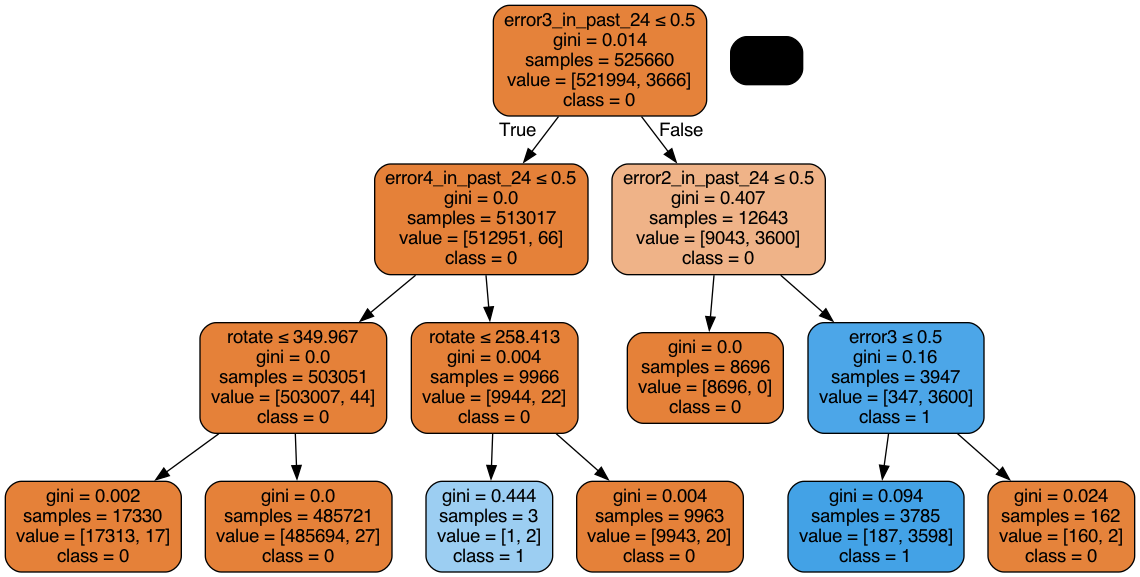

In [23]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model_a, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=list(X_train.columns)[1:], class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decision_tree.png')
Image(graph.create_png())

### Visualize Data Near Failure

In [27]:
import copy
import matplotlib.pyplot as plt
from datetime import datetime

first_fail = "2015-04-20 06:00:00"
variables = ["error3", "error3_in_past_24", "error2", "error2_in_past_24", "failure_comp2"]
ts = "2015-04-18 06:00:00"
tf = "2015-04-20 09:00:00"

data = copy.deepcopy(X_train)
data = data.join(y_train)
data = data.loc[data.machineID == 1]
t = datetime(year=2015, month=4, day=20, hour=6)

In [25]:
first_fail = "2015-06-09 06:00:00"
variables = ["error3", "error3_in_past_24", "error2", "error2_in_past_24", "failure_comp2"]
ts = "2015-06-08 03:00:00"
tf = "2015-06-09 09:00:00"

data = copy.deepcopy(X_train)
data = data.join(y_train)
data = data.loc[data.machineID == 1]
t = datetime(year=2015, month=6, day=9, hour=6)

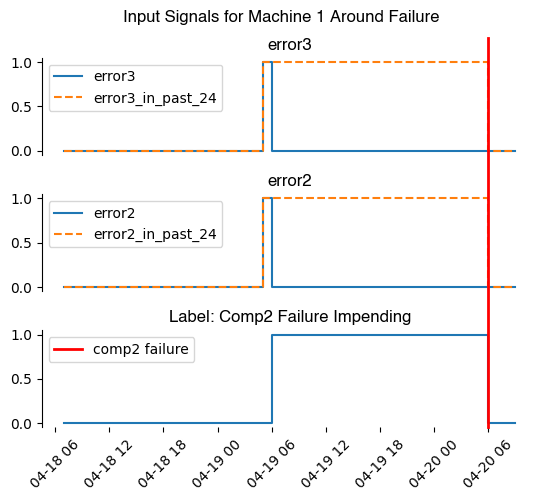

In [28]:
from datetime import datetime

sample = data.loc[(data['datetime'] > ts) & (data['datetime'] <= tf)]
hfont = {'fontname':'Helvetica'}

ax = plt.subplot(3, 1, 1)

plt.title("error3", **hfont)
line_one, = plt.step(sample["datetime"], sample[variables[0]], "-")
line_one.set_label(variables[0])
line_two, = plt.step(sample["datetime"], sample[variables[1]], "--")
line_two.set_label(variables[1])
plt.xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.legend()

ax = plt.subplot(3, 1, 2)
plt.title("error2", **hfont)
line_three, = plt.step(sample["datetime"], sample[variables[2]])
line_three.set_label(variables[2])
line_four, = plt.step(sample["datetime"], sample[variables[3]], "--")
line_four.set_label(variables[3])
plt.xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.legend()

ax = plt.subplot(3, 1, 3)
plt.title("Label: Comp2 Failure Impending", **hfont)
plt.step(sample["datetime"], sample[variables[4]])
red_line = plt.axvline(t, color="r", linewidth=2, clip_on=False, ymax=4)
red_line.set_label("comp2 failure")
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.legend()
plt.xticks(rotation = 45)

fig = plt.gcf()
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Input Signals for Machine 1 Around Failure", **hfont)
plt.show()

## Model Training In Sagemaker

In [29]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))
role = 'arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579'
print("RoleArn: {}".format(role))

AWS Region: us-west-1
RoleArn: arn:aws:iam::328535504136:role/service-role/AmazonSageMaker-ExecutionRole-20230208T093579


In [31]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)
xgb_model.set_hyperparameters(
    max_depth = 4,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 500
)

746614075791.dkr.ecr.us-west-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [32]:
from sagemaker.session import TrainingInput
train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train_02_12_12.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation_02_12_12.csv"), content_type="csv"
)

#### TRAIN MODEL

In [33]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-12-20-01-03-815


2023-02-12 20:01:04 Starting - Starting the training job...CreateXgboostReport: InProgress
...
2023-02-12 20:01:49 Starting - Preparing the instances for training...
2023-02-12 20:02:31 Downloading - Downloading input data...
2023-02-12 20:03:01 Training - Downloading the training image......
2023-02-12 20:03:57 Training - Training image download completed. Training in progress..[2023-02-12 20:04:06.534 ip-10-0-165-147.us-west-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delim

#### Deploy Model to Sagemaker

In [34]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-02-12-20-17-51-204
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-02-12-20-17-51-204
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-02-12-20-17-51-204


--------!

In [36]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2023-02-12-20-17-51-204'

## Evaluation

Getting predictions for the test set from the cloud model.

In [40]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

inputd = test.to_numpy()[:,1:]
inputd[:, 0] = 0
inputd[:, 6] = 0
inputd[:, 8] = 0
predictions=predict(inputd)

### Arbitrary Cutoff

With an arbitrary cutoff, the confusion matrix is,

In [42]:
import sklearn
cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[173937     59]
 [    11   1213]]


The classification report is as follows, (note especially precision, recall, and f1-score, for postive labels 1.0)

In [43]:
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    173996
         1.0       0.95      0.99      0.97      1224

    accuracy                           1.00    175220
   macro avg       0.98      1.00      0.99    175220
weighted avg       1.00      1.00      1.00    175220



### "Improved" Cutoff

In predictive maintenance, false negatives tend to be the most costly, so by lowering the cutoff we can reduce the false negatives at the expense of an increased number of false positives.

In [44]:
cutoff=0.2
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[173936     60]
 [     1   1223]]


Recall increases to 0.77 which means we catch more failures beforehand.

In [45]:
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    173996
         1.0       0.95      1.00      0.98      1224

    accuracy                           1.00    175220
   macro avg       0.98      1.00      0.99    175220
weighted avg       1.00      1.00      1.00    175220

